# Kaggle 機械学習の流れ

このカーネルを例に行う  
https://www.kaggle.com/code1110/houseprice-data-cleaning-visualization

https://qiita.com/katsu1110/items/a1c3185fec39e5629bcb


## 1.データを集める


In [62]:
# 基本的にはcsvファイルが多そうなので

import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


## 2.前処理を行う, EDA (Exploratory Data Analysis)
  
まずは、データがどういう構造なのか探っていく    

・まずはデータタイプと数を調べる dtypes shape  
・全て数値に変換する （Label Encoder）  
・NaNは再現性のある数値で埋める isnull().sum()で見れる⇒mean, median等で埋める   
・新しい特徴量をつくる　同じようなものはまとめる、ランダムフォレストを利用等

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
pd.set_option('display.max_rows', None) # 行が省略されるのを防ぐ
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [65]:
# データの数もみておく
train.shape

# データは1480個で81のカラムがある

(1460, 81)

In [67]:
test.shape # カラムが一個ないのは予測するためのものが落ちてるからである

(1459, 80)

In [68]:
# objectの中身を見てみよう　Utilitiesというカラムを見る
train.iloc[:,9].values

array(['AllPub', 'AllPub', 'AllPub', ..., 'AllPub', 'AllPub', 'AllPub'],
      dtype=object)

In [69]:
# objectは基本的には文字情報で、このままだとモデルに与えることはできない
# そこで登場するのが、Label Encoder です。

from sklearn.preprocessing import LabelEncoder

for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))


In [70]:
# もっかいobjectの中身を見てみよう　Utilitiesというカラムを見る
train.iloc[:,9].values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [71]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning           int64
LotFrontage      float64
LotArea            int64
Street             int64
Alley              int64
LotShape           int64
LandContour        int64
Utilities          int64
LotConfig          int64
LandSlope          int64
Neighborhood       int64
Condition1         int64
Condition2         int64
BldgType           int64
HouseStyle         int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle          int64
RoofMatl           int64
Exterior1st        int64
Exterior2nd        int64
MasVnrType         int64
MasVnrArea       float64
ExterQual          int64
ExterCond          int64
Foundation         int64
BsmtQual           int64
BsmtCond           int64
BsmtExposure       int64
BsmtFinType1       int64
BsmtFinSF1         int64
BsmtFinType2       int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating            int64


In [72]:
# NaNに対処する
# train.isnull().sum()
# test.isnull().sum() でもいいがこの方がNaNがあるものだけ表示してくれるので楽

# Which columns have nan?
print('training data+++++++++++++++++++++')
for i in np.arange(train.shape[1]):
    n = train.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(train.columns.values)[i] + ': ' + str(n) + ' nans')

print('testing data++++++++++++++++++++++ ')
for i in np.arange(test.shape[1]):
    n = test.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(test.columns.values)[i] + ': ' + str(n) + ' nans')

training data+++++++++++++++++++++
LotFrontage: 259 nans
MasVnrArea: 8 nans
GarageYrBlt: 81 nans
testing data++++++++++++++++++++++ 
LotFrontage: 227 nans
MasVnrArea: 15 nans
BsmtFinSF1: 1 nans
BsmtFinSF2: 1 nans
BsmtUnfSF: 1 nans
TotalBsmtSF: 1 nans
BsmtFullBath: 2 nans
BsmtHalfBath: 2 nans
GarageYrBlt: 78 nans
GarageCars: 1 nans
GarageArea: 1 nans


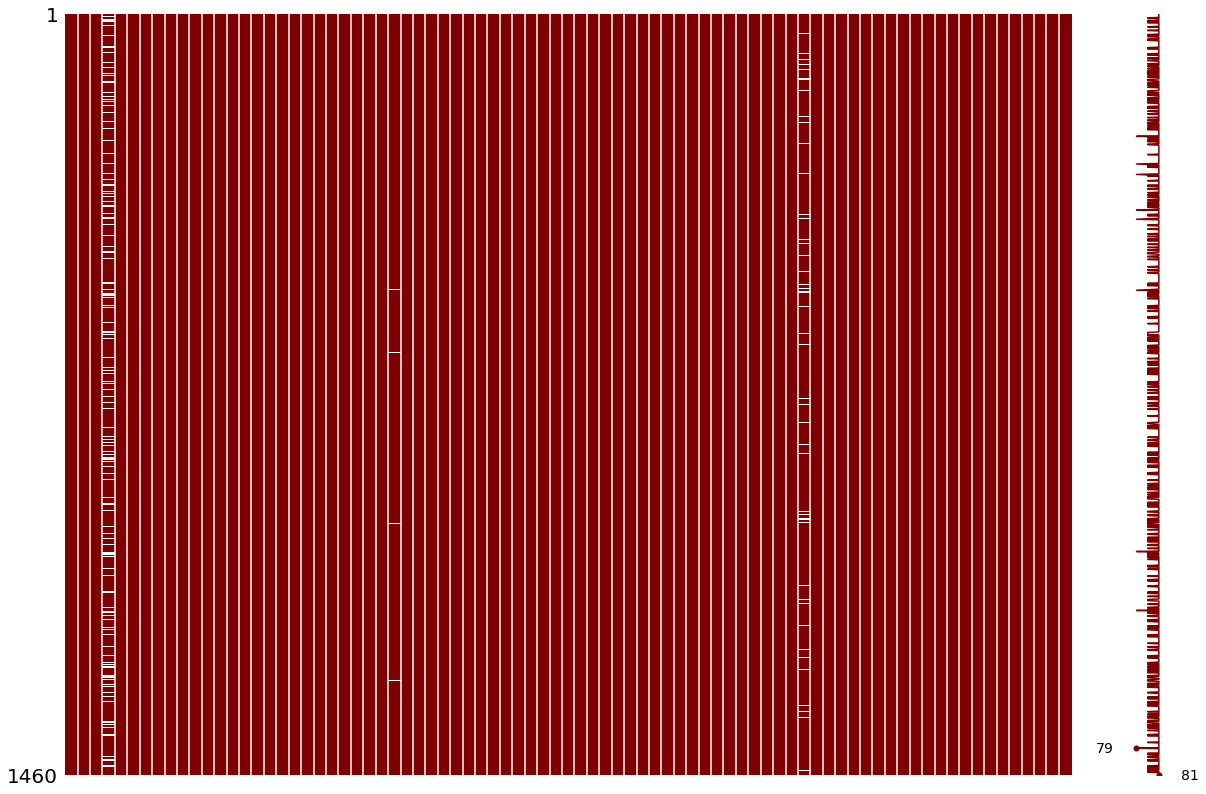

In [73]:
# NaNだけを可視化できるライブラリもあるので使える
# 白いところが欠損値NaNである

# pip install missingno
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [74]:
# これらのNaNをどうするか
# 今回はNaNがtraining, testデータともに多いものはマトリックスから落とし、
# それ以外はその列の中央値 (median)で埋めることにする


# 先に提出用のデータ形式を作っておく
# keep ID for submission
train_ID = train['Id']
test_ID = test['Id']
# split data for training
y_train = train['SalePrice']
X_train = train.drop(['Id','SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)


# これでX_train, y_train, X_testと分けられたのでここから処理していく


# dealing with missing data
# NaNが多いカラムは決して、それ以外はmedianで埋める
Xmat = pd.concat([X_train, X_test])
Xmat = Xmat.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
Xmat = Xmat.fillna(Xmat.median())

Xmat null check
check end


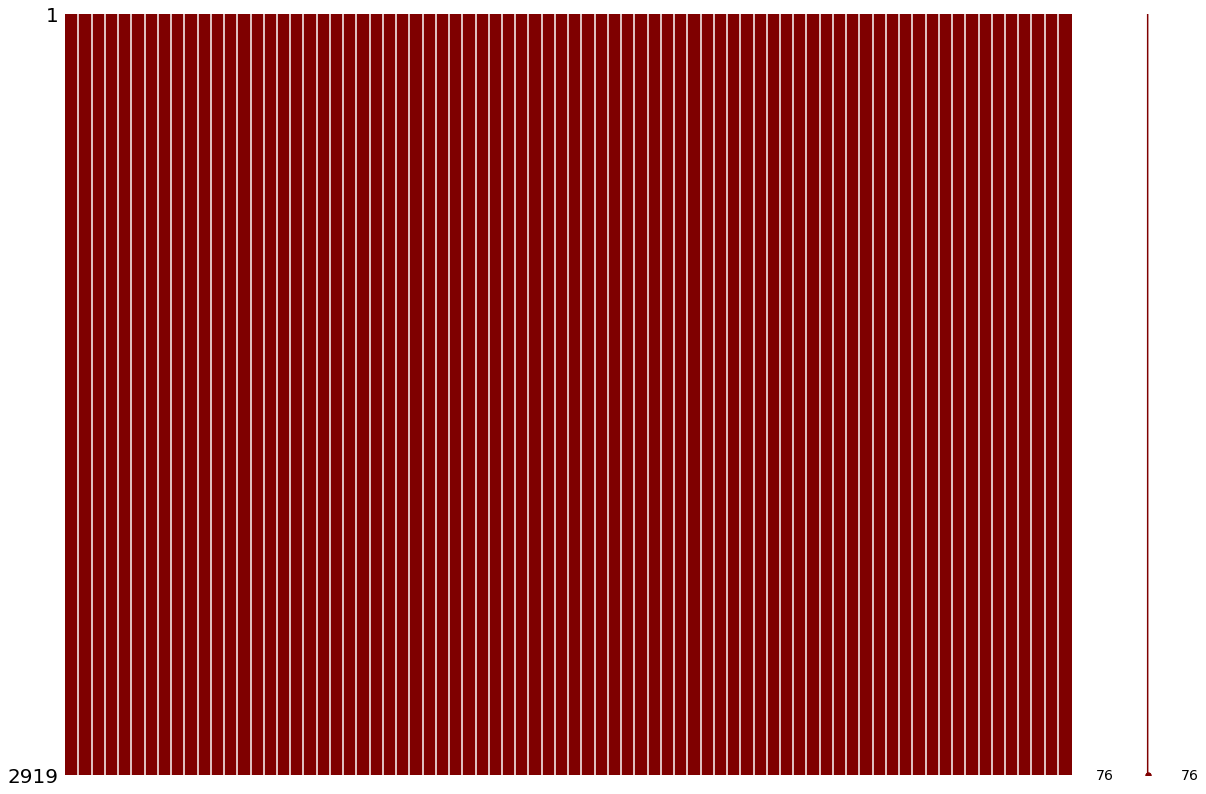

In [79]:
# check whether there are still nan

print('Xmat null check')
for i in np.arange(Xmat.shape[1]):
    n = Xmat.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(Xmat.columns.values)[i] + ': ' + str(n) + ' nans')
print('check end')

import missingno as msno
msno.matrix(df=Xmat, figsize=(20,14), color=(0.5,0,0))

In [56]:
# NaNがなくなった！

In [81]:
# 特徴量を観察して新しい特徴量を作る
print(Xmat.columns.values)
print(str(Xmat.shape[1]) + ' columns')

['MSSubClass' 'MSZoning' 'LotArea' 'Street' 'Alley' 'LotShape'
 'LandContour' 'Utilities' 'LotConfig' 'LandSlope' 'Neighborhood'
 'Condition1' 'Condition2' 'BldgType' 'HouseStyle' 'OverallQual'
 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle' 'RoofMatl'
 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond'
 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual' 'TotRmsAbvGrd'
 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType' 'GarageFinish'
 'GarageCars' 'GarageArea' 'GarageQual' 'GarageCond' 'PavedDrive'
 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch'
 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature' 'MiscVal' 'MoSold' 'YrSold'
 'SaleType' 'SaleCondition']
76 columns


In [82]:
# SFが多いのでまとめる
# add a new feature 'total sqfootage'
Xmat['TotalSF'] = Xmat['TotalBsmtSF'] + Xmat['1stFlrSF'] + Xmat['2ndFlrSF']
print('There are currently ' + str(Xmat.shape[1]) + ' columns.')

There are currently 77 columns.


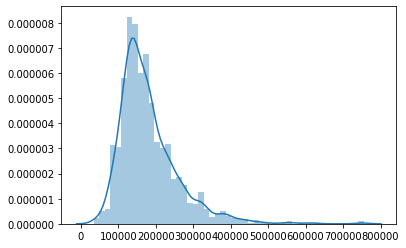

In [84]:
#Regressionの場合、ターゲットの値がどちらかに偏らず正規分布に従っていることが重要。
#今回のターゲット、SalePriceは正規分布に従っているでしょうか？

# normality check for the target
ax = sns.distplot(tuple(y_train))
plt.show()

In [85]:
#　……従って……ない……
# このままだとモデルのパフォーマンスに影響するので、logを使って疑似的に正規分布に持っていきます。

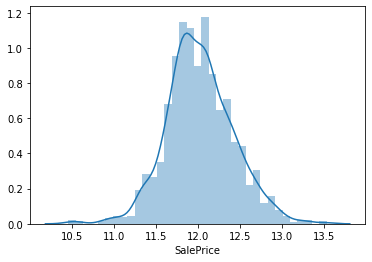

In [86]:
# log-transform the dependent variable for normality
y_train = np.log(y_train)

ax = sns.distplot(y_train)
plt.show()

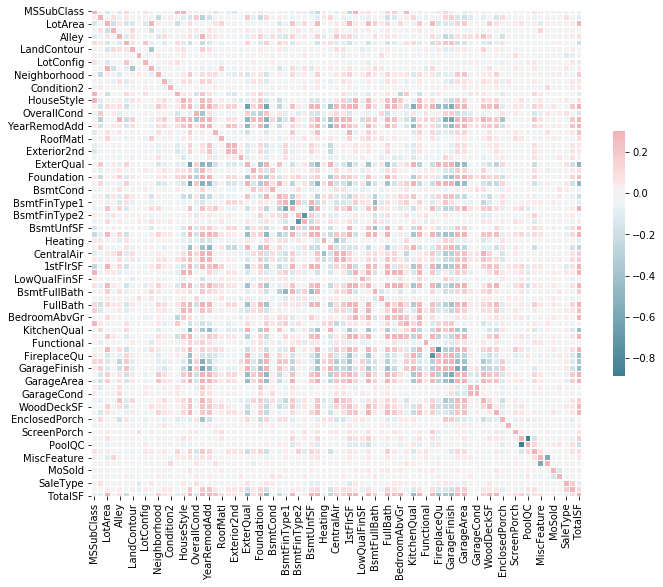

In [88]:
# どのFeatureが大切なのかチェックする

# とりあえず相関図でも見てみる


# train and test
X_train = Xmat.iloc[:train.shape[0],:]
X_test = Xmat.iloc[train.shape[0]:,:]

# Compute the correlation matrix
corr = X_train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Training done using Random Forest


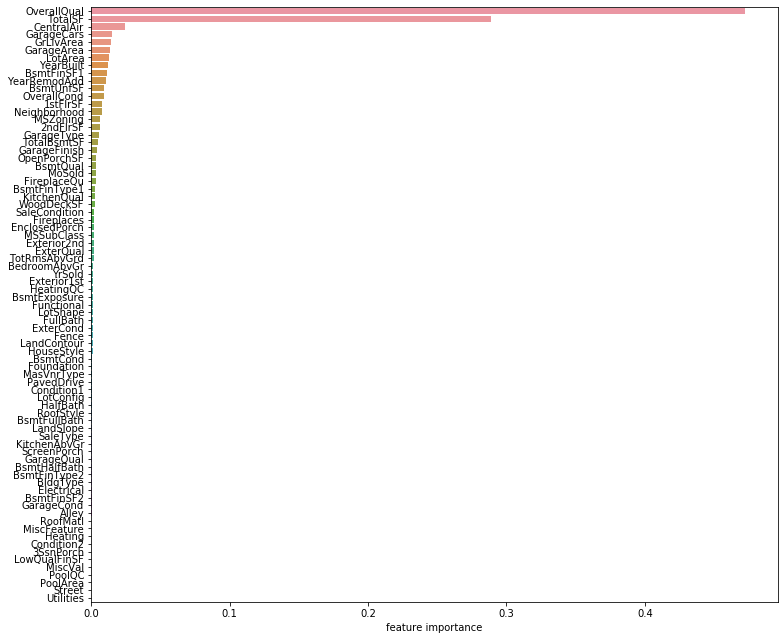

In [89]:
# 特徴量が多すぎて見にくすぎる.....


# 現在、70をこえるFeatureがある。何も考えずに全てをモデルに投げるのも手ですが、
# 逆に、モデルにどのFeatureが予測に大切か教えてもらいましょう。
# 今回は、ランダムフォレスト (Regressor)を使います。
# feature importance using random forest

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()


# sklearnのランダムフォレストのfeature_importance_を見ることにより
# どのFeatureがどれくらい大切か、概観を得ることができます。

In [90]:
# ……って、上2つ ('OverallQual' & 'TotalSF')がぶっちぎりじゃなイカ！ｗｗ

# つまり、70以上あるFeatureの中で、SalePriceの予測に大切なのはほんの数個しかない、ということがわかります。

# まぁでも、とりあえず上30個のFeatureを取ってきて、それをモデルに与え、訓練することにします。
# そして、上2つのFeatureを掛け合わせたものを、'Interaction'として新しいFeatureを作ります。

In [91]:
# use the top 30 features only
X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]

# interaction between the top 2
X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]

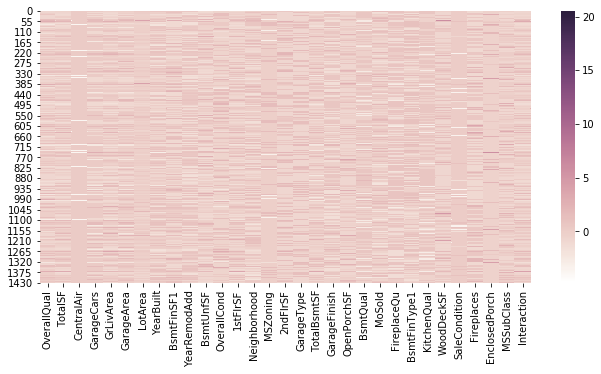

In [92]:
# zscoring
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
    
# heatmap
f, ax = plt.subplots(figsize=(11, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(X_train, cmap=cmap)
plt.show()

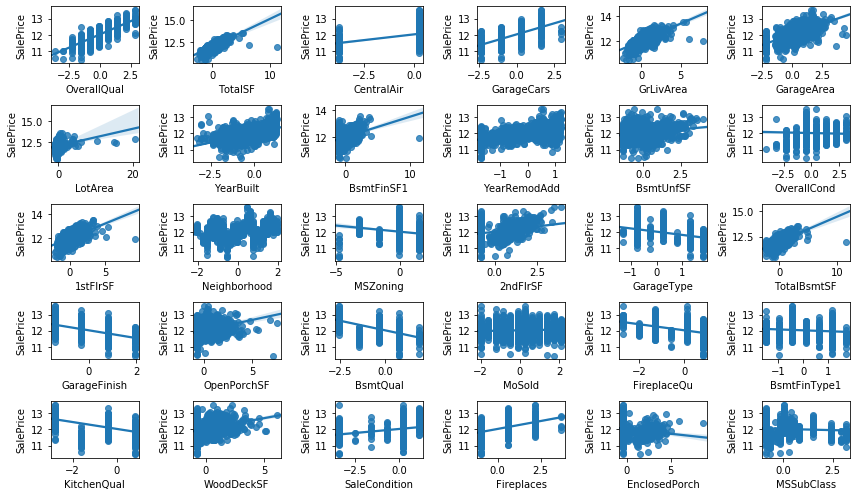

In [95]:
# 現在、Interactionを入れてもせいぜい31個しかFeatureがないので、vs SalePriceをすべてプロットしてみましょう。
# relation to the target

fig = plt.figure(figsize=(12,7))
for i in np.arange(30):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=X_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

In [96]:
#外れ値を除く
# 　マニュアルで、'TotalSF'と'GrLivArea'に見られた外れ値をマトリックスから除きます。

# outlier deletion
Xmat = X_train
Xmat['SalePrice'] = y_train
Xmat = Xmat.drop(Xmat[(Xmat['TotalSF']>5) & (Xmat['SalePrice']<12.5)].index)
Xmat = Xmat.drop(Xmat[(Xmat['GrLivArea']>5) & (Xmat['SalePrice']<13)].index)

# recover
y_train = Xmat['SalePrice']
X_train = Xmat.drop(['SalePrice'], axis=1)

In [97]:
# 　以上で、EDAパート/前処理は終了です。とうとう、モデリングの段階へと移行します。

## モデリング

Stacking-Emsemble modelを作る  
　例えば、Deep Learningだけを使って予測値を求めてもいいのですが、多くの場合、アンサンブル (Emsemble)といって、複数のモデルの予測結果を平均した方がより良い予測に繋がる場合が多いです。今回は、機械学習モデルの最終兵器と名高いXGBoost、最近はみんな知っているNeural Network、昔も今もずっと活躍Support Vector Regressorの3つのモデルを別々に訓練し、結果を平均して提出したいと思います。  
  
　ただ、もしかしたらXGBoostが他のモデルより圧倒的に良かったりするかもしれません。その場合、XGBoostの結果をより重んじたいですよね。つまり、  
  
yprediction=w1∗XGB+w2∗NN+w3∗SVR  
yprediction=w1∗XGB+w2∗NN+w3∗SVR  
　のときのw1w1 を他よりも大きくしたい。  
  
「あれっ……これってもう一つのRegressionなんじゃないの？」  
  
　と最初に考えた人はすごいですよね。これがスタッキング (Stacking)と呼ばれる手法で、複数のモデルの加重平均 (weighted average)によって全体の予測値を決定します。つまり、各モデルの予測値を新しい、第２のマトリックスと捉え、再びRegressionの手法を用いて最適なww の値を決めていくわけです。  
   
　ざっくり、各モデルによるトレーニングは以下のようになります。いずれのモデルも複数のハイパーパラメーター (hyperparameter) が存在する複雑なモデルですので、グリッドサーチ (Grid Search)を用いて、しらみつぶしに最適なモデルパラメーターを決定しようと試みています。  

In [100]:
# XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(X_train, y_train)

print('-'*100)
print(reg_xgb.best_score_)
print(reg_xgb.best_params_)

Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[00:59:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:59:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:59:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:59:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:59:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:59:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:59:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    9.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:59:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
0.9020589993822492
{'max_depth': 4, 'n_estimators': 200}


In [101]:
# Neural Network

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD','Adam']
batch_size = [10, 30, 50]
# epochs = [10, 50, 100]
epochs= [1,1,1]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)
reg_dl = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
reg_dl.fit(X_train, y_train)

print('-'*100)
print(reg_xgb.best_score_)
print(reg_xgb.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [102]:
# Support Vector Regressor

# SVR
from sklearn.svm import SVR

reg_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg_svr.fit(X_train, y_train)

print('-'*100)
print(reg_svr.best_score_)
print(reg_svr.best_params_)


----------------------------------------------------------------------------------------------------
0.9047526705560093
{'C': 1.0, 'gamma': 0.01}


In [103]:
# second feature matrix
X_train2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_train),
#      'NN': reg_dl.predict(X_train).ravel(),
     'SVR': reg_svr.predict(X_train),
    })
X_train2.head()

,XGB,SVR
0,12.240315,12.211700
1,12.107360,12.136536
2,12.271962,12.268204
3,11.885964,11.949866
4,12.537979,12.542085


In [104]:
# 上5行だけ見てみると、どのモデルも比較的近い値を予測していますね。

# では、最も単純な線形モデルを使って、各モデルの重みを決定し、最終的な全体の予測値を計算しましょう。
# 最後に、ターゲットをlogにしていたので、expを使って元のスケールに戻すことを忘れないでください。

In [106]:
# second-feature modeling using linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)

# prediction using the test set
X_test2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_test),
#      'DL': reg_dl.predict(X_test).ravel(),
     'SVR': reg_svr.predict(X_test),
    })

# Don't forget to convert the prediction back to non-log scale
y_pred = np.exp(reg.predict(X_test2))

# submission
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": y_pred
})
submission.to_csv('houseprice.csv', index=False)